# libraries

If needed for import pykalman

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from numpy import unique
from numpy import where
from sklearn.mixture import GaussianMixture
from pykalman import KalmanFilter

# Import data sets

In [2]:
ETF_universe = pd.read_csv('C:\\Users\\Baptiste\\Downloads\\Project ETF\\ETF_Universe.csv')
Macro_factors = pd.read_csv('C:\\Users\\Baptiste\\Downloads\\Project ETF\\Macro_Factors.csv')
Mystery_allocation = pd.read_csv('C:\\Users\\Baptiste\\Downloads\\Project ETF\\Mystery_Allocation.csv')
Mystery_allocation_v2 = pd.read_csv('C:\\Users\\Baptiste\\Downloads\\Project ETF\\Mystery_Allocation_v2.csv')

# Typologie of data

In [3]:
Macro_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4499 entries, 0 to 4498
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              4499 non-null   object 
 1   US S&P 500              4499 non-null   float64
 2   EU Stoxx 600            4499 non-null   float64
 3   Japan Nikkei 225        4499 non-null   float64
 4   MSCI EM USD             4499 non-null   float64
 5   US HY                   4499 non-null   float64
 6   EU HY                   4499 non-null   float64
 7   BCOM Energy             4499 non-null   float64
 8   BCOM Industrial Metals  4499 non-null   float64
 9   BCOM Gold               4499 non-null   float64
 10  Dollar Index            4499 non-null   float64
 11  US 10Y Bond             4499 non-null   float64
 12  Germany Bund 10Y        4499 non-null   float64
dtypes: float64(12), object(1)
memory usage: 457.1+ KB


In [4]:
ETF_universe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Columns: 102 entries, Unnamed: 0 to ETF_101
dtypes: float64(101), object(1)
memory usage: 464.7+ KB


# Locking timestamp starting from 2021 for macro factors

In [5]:
start_date = '2021-01-04'
end_date = '2023-03-29'

# convert the date column to a datetime type
Macro_factors['Unnamed: 0'] = pd.to_datetime(Macro_factors['Unnamed: 0'])

# create a boolean mask to select the rows between start_date and end_date
mask = (Macro_factors['Unnamed: 0'] >= start_date) & (Macro_factors['Unnamed: 0'] <= end_date)

Macro_factors_2021 = Macro_factors.loc[mask]

In [6]:
ETF_universe

Unnamed: 0       ETF_1       ETF_2       ETF_3       ETF_4       ETF_5  \
0    2021-01-04  100.000000  100.000000  100.000000  100.000000  100.000000   
1    2021-01-05  100.664447  100.083922   99.252395  102.032069  100.041029   
2    2021-01-06   98.549788   99.519065   98.364484  107.519936   99.698544   
3    2021-01-07   99.735901   98.684154   99.717292  114.954919  101.233032   
4    2021-01-08  101.813931  101.323378   99.264960  116.151961  103.332426   
..          ...         ...         ...         ...         ...         ...   
578  2023-03-23   74.868592  113.657686  121.902518   68.095661  106.478710   
579  2023-03-24   75.202682  111.067955  119.537197   67.401513  106.473096   
580  2023-03-27   74.952348  111.341238  121.790482   67.562456  106.564655   
581  2023-03-28   74.244973  109.850017  122.177896   67.566298  106.665717   
582  2023-03-29   75.220880  112.782966  122.357992   68.850003  107.810212   

          ETF_6       ETF_7       ETF_8       ETF_9  ...      ETF_92  \
0    100.000000  100.000000  100.000000  100.000000  ...  100.000000   
1    100.269482   99.779466  101.721018   99.633393  ...   99.990476   
2     99.834420  101.532557  101.561550   99.624949  ...   99.972549   
3    101.019559  103.712486  104.576537   99.222455  ...   99.970309   
4    103.120770  104.025163  105.525583   95.806184  ...   99.974790   
..          ...         ...         ...         ...  ...         ...   
578   86.832247   90.525182  117.126901   82.487299  ...   96.191100   
579   86.952706   90.170160  115.425105   83.089632  ...   96.368688   
580   86.510194   90.180661  114.424591   83.051635  ...   96.249923   
581   87.146849   90.373417  113.297791   84.563097  ...   96.126676   
582   87.045017   91.166796  116.201824   84.356221  ...   96.113791   

         ETF_93      ETF_94      ETF_95      ETF_96      ETF_97      ETF_98  \
0    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1    100.840152  101.002981  100.739760   99.536130   99.813980   99.603933   
2    100.057308  102.128050  101.231133  101.309788   99.944805  100.964540   
3    101.206768  103.191639  102.864413  101.628140  101.677728  101.444481   
4    102.608099  103.597696  103.454080  102.263032  103.375352  102.152742   
..          ...         ...         ...         ...         ...         ...   
578   97.192487  109.206061  106.271420  123.709405  112.732806  116.224780   
579   96.230280  108.603153  106.829062  121.535832  112.591472  114.137272   
580   96.112236  109.833182  107.029701  122.535942  112.921116  115.208984   
581   97.452443  110.583040  106.854142  122.641585  113.302632  115.264899   
582   97.798749  112.021290  108.403404  124.497194  114.839521  116.923722   

         ETF_99     ETF_100     ETF_101  
0    100.000000  100.000000  100.000000  
1    100.854623  100.202380  100.031821  
2     99.444345  102.497743  100.158991  
3    101.936676  102.922817  100.254745  
4    103.242398  103.967763  100.326256  
..          ...         ...         ...  
578  101.517271  136.156331  102.581525  
579  101.818816  135.991859  102.208289  
580  101.069376  136.940118  102.276907  
581  100.570910  138.793038  102.132843  
582  102.448725  141.634001  102.671261  

[583 rows x 102 columns]

# Merge ETFs and Macro factors

In [7]:
ETF_universe["Unnamed: 0"] = pd.to_datetime(ETF_universe["Unnamed: 0"])
Macro_factors_2021["Unnamed: 0"] = pd.to_datetime(Macro_factors_2021["Unnamed: 0"])

merged_df = pd.merge(ETF_universe, Macro_factors_2021, on='Unnamed: 0')

C:\Users\Baptiste\AppData\Local\Temp\ipykernel_13256\301349646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Macro_factors_2021["Unnamed: 0"] = pd.to_datetime(Macro_factors_2021["Unnamed: 0"])


In [8]:
merged_df

Unnamed: 0       ETF_1       ETF_2       ETF_3       ETF_4       ETF_5  \
0   2021-01-04  100.000000  100.000000  100.000000  100.000000  100.000000   
1   2021-01-05  100.664447  100.083922   99.252395  102.032069  100.041029   
2   2021-01-06   98.549788   99.519065   98.364484  107.519936   99.698544   
3   2021-01-07   99.735901   98.684154   99.717292  114.954919  101.233032   
4   2021-01-08  101.813931  101.323378   99.264960  116.151961  103.332426   
..         ...         ...         ...         ...         ...         ...   
578 2023-03-23   74.868592  113.657686  121.902518   68.095661  106.478710   
579 2023-03-24   75.202682  111.067955  119.537197   67.401513  106.473096   
580 2023-03-27   74.952348  111.341238  121.790482   67.562456  106.564655   
581 2023-03-28   74.244973  109.850017  122.177896   67.566298  106.665717   
582 2023-03-29   75.220880  112.782966  122.357992   68.850003  107.810212   

          ETF_6       ETF_7       ETF_8       ETF_9  ...  Japan Nikkei 225  \
0    100.000000  100.000000  100.000000  100.000000  ...          45047.04   
1    100.269482   99.779466  101.721018   99.633393  ...          44882.19   
2     99.834420  101.532557  101.561550   99.624949  ...          44712.49   
3    101.019559  103.712486  104.576537   99.222455  ...          45430.03   
4    103.120770  104.025163  105.525583   95.806184  ...          46502.40   
..          ...         ...         ...         ...  ...               ...   
578   86.832247   90.525182  117.126901   82.487299  ...          47135.61   
579   86.952706   90.170160  115.425105   83.089632  ...          47076.54   
580   86.510194   90.180661  114.424591   83.051635  ...          47234.21   
581   87.146849   90.373417  113.297791   84.563097  ...          47305.34   
582   87.045017   91.166796  116.201824   84.356221  ...          47931.69   

     MSCI EM USD     US HY     EU HY  BCOM Energy  BCOM Industrial Metals  \
0        630.517  318.0612  207.4194      20.2183                135.4156   
1        638.034  318.1225  207.4808      21.1276                137.4571   
2        635.789  318.4568  207.6067      21.3284                138.1451   
3        639.180  318.7039  207.7834      21.3946                139.5059   
4        654.287  318.8697  207.9640      21.6744                137.6681   
..           ...       ...       ...          ...                     ...   
578      498.360  302.7537  197.9170      31.9448                157.4597   
579      495.640  301.4518  197.5785      31.9028                157.8276   
580      491.570  301.6986  197.8065      32.5105                158.9371   
581      495.010  301.1921  198.0427      32.4988                159.9763   
582      499.940  303.0247  198.4324      32.3383                159.8253   

     BCOM Gold  Dollar Index  US 10Y Bond  Germany Bund 10Y  
0     216.1090      1040.289     1182.058          1790.415  
1     216.9749      1043.137     1178.733          1788.087  
2     211.8903      1039.544     1171.182          1775.302  
3     212.4454      1043.476     1168.254          1778.542  
4     203.7637      1043.282     1164.786          1778.409  
..         ...           ...          ...               ...  
578   212.0417      1199.509      967.847          1275.453  
579   210.8200      1210.312      969.057          1302.301  
580   207.6393      1208.977      958.155          1278.860  
581   209.6299      1203.988      954.861          1269.141  
582   209.0085      1206.116      953.817          1268.506  

[583 rows x 114 columns]

In [9]:
merged_df.dtypes

Unnamed: 0                datetime64[ns]
ETF_1                            float64
ETF_2                            float64
ETF_3                            float64
ETF_4                            float64
                               ...      
BCOM Industrial Metals           float64
BCOM Gold                        float64
Dollar Index                     float64
US 10Y Bond                      float64
Germany Bund 10Y                 float64
Length: 114, dtype: object

# Series visualization

Text(0.5, 1.0, 'ETF prices')

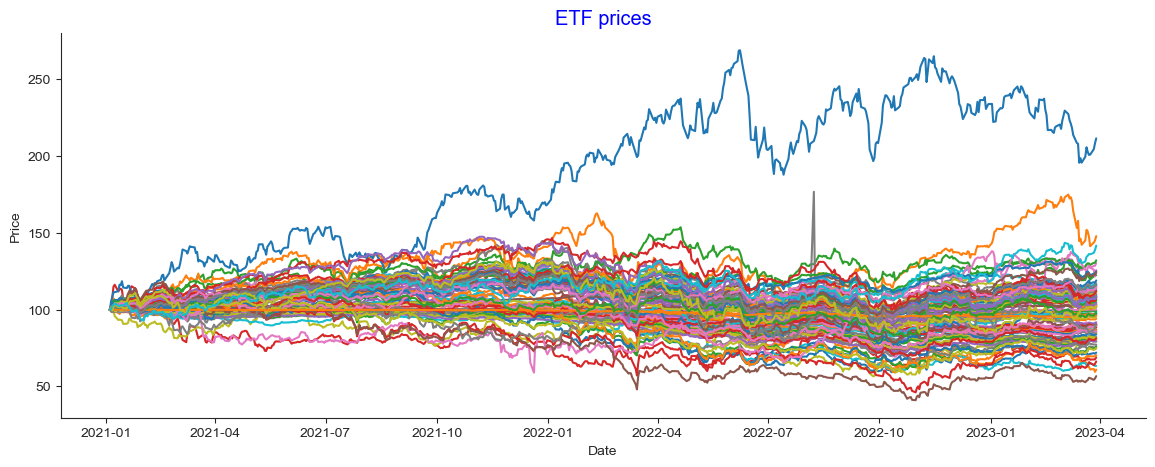

In [10]:
plt.figure(figsize=(14,5))

seaborn.set_style("ticks")

bound = np.arange(1,101,1)
for i in bound:
    seaborn.lineplot(data=merged_df,x="Unnamed: 0",y='ETF_' + str(i))

seaborn.despine()
plt.ylabel('Price')
plt.xlabel('Date')
plt.title("ETF prices",size='x-large',color='blue')

# Moments, returns and coefficient of variation

In [11]:
merged_df2 = merged_df.drop('Unnamed: 0', axis=1)
merged_df2

ETF_1       ETF_2       ETF_3       ETF_4       ETF_5       ETF_6  \
0    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1    100.664447  100.083922   99.252395  102.032069  100.041029  100.269482   
2     98.549788   99.519065   98.364484  107.519936   99.698544   99.834420   
3     99.735901   98.684154   99.717292  114.954919  101.233032  101.019559   
4    101.813931  101.323378   99.264960  116.151961  103.332426  103.120770   
..          ...         ...         ...         ...         ...         ...   
578   74.868592  113.657686  121.902518   68.095661  106.478710   86.832247   
579   75.202682  111.067955  119.537197   67.401513  106.473096   86.952706   
580   74.952348  111.341238  121.790482   67.562456  106.564655   86.510194   
581   74.244973  109.850017  122.177896   67.566298  106.665717   87.146849   
582   75.220880  112.782966  122.357992   68.850003  107.810212   87.045017   

          ETF_7       ETF_8       ETF_9      ETF_10  ...  Japan Nikkei 225  \
0    100.000000  100.000000  100.000000  100.000000  ...          45047.04   
1     99.779466  101.721018   99.633393  100.025174  ...          44882.19   
2    101.532557  101.561550   99.624949  100.121489  ...          44712.49   
3    103.712486  104.576537   99.222455  100.238511  ...          45430.03   
4    104.025163  105.525583   95.806184  100.473455  ...          46502.40   
..          ...         ...         ...         ...  ...               ...   
578   90.525182  117.126901   82.487299   99.325409  ...          47135.61   
579   90.170160  115.425105   83.089632   99.410211  ...          47076.54   
580   90.180661  114.424591   83.051635   98.971767  ...          47234.21   
581   90.373417  113.297791   84.563097   98.612283  ...          47305.34   
582   91.166796  116.201824   84.356221   98.769557  ...          47931.69   

     MSCI EM USD     US HY     EU HY  BCOM Energy  BCOM Industrial Metals  \
0        630.517  318.0612  207.4194      20.2183                135.4156   
1        638.034  318.1225  207.4808      21.1276                137.4571   
2        635.789  318.4568  207.6067      21.3284                138.1451   
3        639.180  318.7039  207.7834      21.3946                139.5059   
4        654.287  318.8697  207.9640      21.6744                137.6681   
..           ...       ...       ...          ...                     ...   
578      498.360  302.7537  197.9170      31.9448                157.4597   
579      495.640  301.4518  197.5785      31.9028                157.8276   
580      491.570  301.6986  197.8065      32.5105                158.9371   
581      495.010  301.1921  198.0427      32.4988                159.9763   
582      499.940  303.0247  198.4324      32.3383                159.8253   

     BCOM Gold  Dollar Index  US 10Y Bond  Germany Bund 10Y  
0     216.1090      1040.289     1182.058          1790.415  
1     216.9749      1043.137     1178.733          1788.087  
2     211.8903      1039.544     1171.182          1775.302  
3     212.4454      1043.476     1168.254          1778.542  
4     203.7637      1043.282     1164.786          1778.409  
..         ...           ...          ...               ...  
578   212.0417      1199.509      967.847          1275.453  
579   210.8200      1210.312      969.057          1302.301  
580   207.6393      1208.977      958.155          1278.860  
581   209.6299      1203.988      954.861          1269.141  
582   209.0085      1206.116      953.817          1268.506  

[583 rows x 113 columns]

In [12]:
Moments = pd.DataFrame(data = merged_df2, index = ['mean', 'stdev', 'returns'])

for column in merged_df2.columns:
    Moments.loc['mean', column] = merged_df2[column].mean()
    Moments.loc['stdev', column] = merged_df2[column].std()
    Moments.loc['returns', column] = (((merged_df2[column].iloc[582] - merged_df2[column].iloc[0]) / merged_df2[column].iloc[0]) *100)
    Moments.loc['coef var', column] = merged_df2[column].std() / merged_df2[column].mean()
    Moments.loc['risk reward', column] = (((merged_df2[column].iloc[582] - merged_df2[column].iloc[0]) / merged_df2[column].iloc[0]) *100) / (merged_df2[column].std() / merged_df2[column].mean())
    Moments.loc['Sharpe ratio', column] = ((((merged_df2[column].iloc[582] - merged_df2[column].iloc[0]) / merged_df2[column].iloc[0]) *100) - 4.72) / merged_df2[column].std()

Moments

ETF_1       ETF_2       ETF_3       ETF_4       ETF_5  \
mean           86.163318  110.611161  116.400217   77.546017  106.507268   
stdev          17.161389   13.287454   10.478816   10.211074    4.129238   
returns       -24.779120   12.782966   22.357992  -31.149997    7.810212   
coef var        0.199173    0.120128    0.090024    0.131678    0.038770   
risk reward  -124.410163  106.411561  248.355841 -236.562594  201.452285   
Sharpe ratio   -1.718924    0.606810    1.683205   -3.512852    0.748374   

                   ETF_6       ETF_7       ETF_8       ETF_9      ETF_10  ...  \
mean           93.415614  106.030659  112.240993   82.658413  102.163730  ...   
stdev           9.809593    8.470541   13.944118   10.836206    3.436454  ...   
returns       -12.954983   -8.833204   16.201824  -15.643779   -1.230443  ...   
coef var        0.105010    0.079888    0.124234    0.131096    0.033637  ...   
risk reward  -123.368800 -110.570325  130.414038 -119.330502  -36.580327  ...   
Sharpe ratio   -1.801806   -1.600040    0.823417   -1.879235   -1.731565  ...   

              Japan Nikkei 225  MSCI EM USD       US HY       EU HY  \
mean              47122.240755   571.416528  313.719423  203.568884   
stdev              1624.776070    73.426632   13.770712    9.422265   
returns               6.403639   -20.709513   -4.727549   -4.332767   
coef var              0.034480     0.128499    0.043895    0.046285   
risk reward         185.720262  -161.164386 -107.701332  -93.609830   
Sharpe ratio          0.001036    -0.346325   -0.686061   -0.960785   

              BCOM Energy  BCOM Industrial Metals   BCOM Gold  Dollar Index  \
mean            37.925627              164.315915  198.213625   1152.923664   
stdev           10.645386               19.197382    8.542641     80.455146   
returns         59.945693               18.025767   -3.285611     15.940474   
coef var         0.280691                0.116832    0.043098      0.069784   
risk reward    213.564643              154.287725  -76.235532    228.427277   
Sharpe ratio     5.187759                0.693103   -0.937135      0.139462   

              US 10Y Bond  Germany Bund 10Y  
mean          1059.905413       1555.875280  
stdev           83.796698        194.707928  
returns        -19.308782        -29.150169  
coef var         0.079061          0.125144  
risk reward   -244.227791       -232.933645  
Sharpe ratio    -0.286751         -0.173954  

[6 rows x 113 columns]

# Visualization

In [13]:
moments = Moments.T
moments_macro = moments.iloc[-12:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


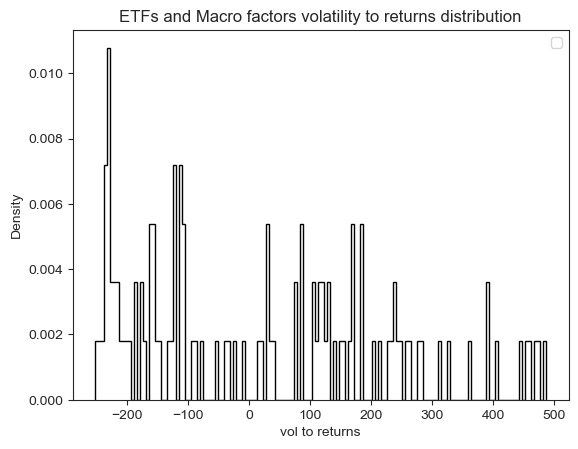

In [14]:
# plot the distributions
fig, ax = plt.subplots()
ax.hist(moments['risk reward'], bins=150, color = 'black', density=True, histtype='step')
ax.legend(loc='upper right')
ax.set_xlabel('vol to returns')
ax.set_ylabel('Density')
ax.set_title('ETFs and Macro factors volatility to returns distribution')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


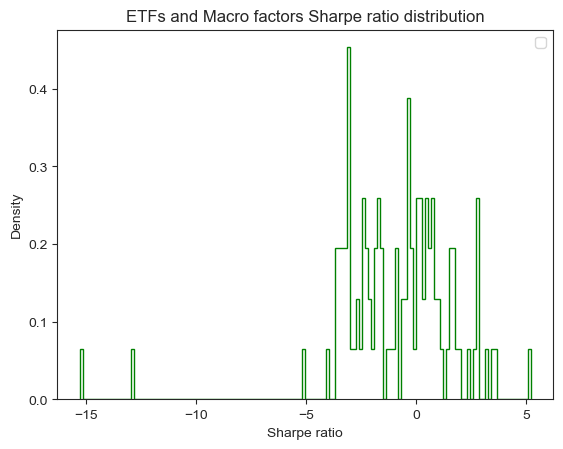

In [15]:
# plot the distributions
fig, ax = plt.subplots()
ax.hist(moments['Sharpe ratio'], bins=150, color = 'green', density=True, histtype='step')
ax.legend(loc='upper right')
ax.set_xlabel('Sharpe ratio')
ax.set_ylabel('Density')
ax.set_title('ETFs and Macro factors Sharpe ratio distribution')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


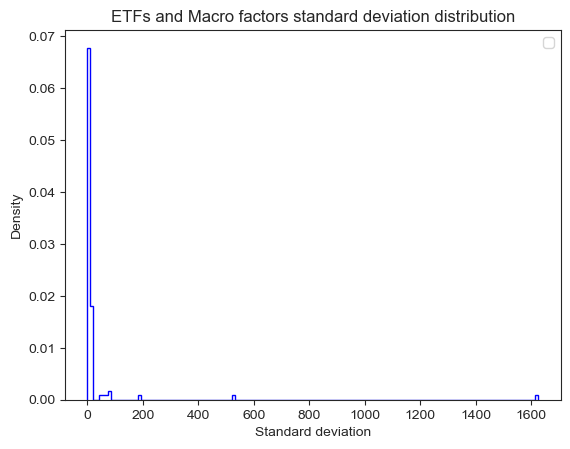

In [16]:
# plot the distributions
fig, ax = plt.subplots()
ax.hist(moments['stdev'], bins=150, color = 'blue', density=True, histtype='step')
ax.legend(loc='upper right')
ax.set_xlabel('Standard deviation')
ax.set_ylabel('Density')
ax.set_title('ETFs and Macro factors standard deviation distribution')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


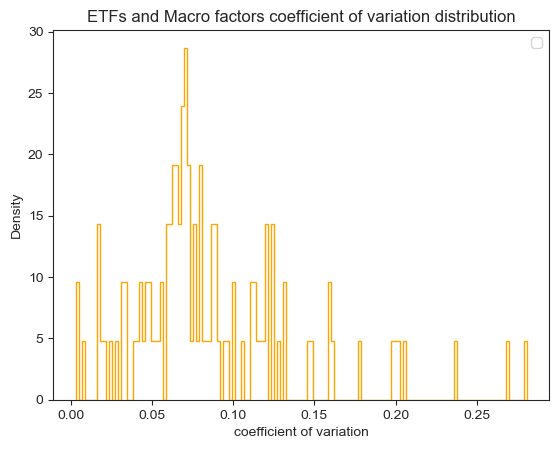

In [17]:
# plot the distributions
fig, ax = plt.subplots()
ax.hist(moments['coef var'], bins=150, color = 'orange', density=True, histtype='step')
ax.legend(loc='upper right')
ax.set_xlabel('coefficient of variation')
ax.set_ylabel('Density')
ax.set_title('ETFs and Macro factors coefficient of variation distribution')
plt.show()

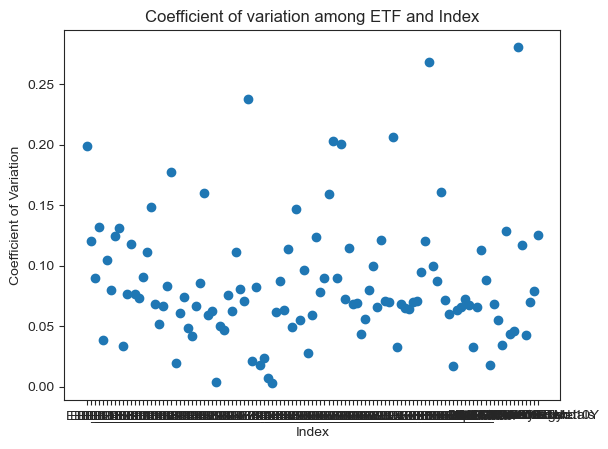

In [18]:
plt.scatter(moments.index, moments['coef var'])

# Set the x-axis label
plt.xlabel('Index')

# Set the y-axis label
plt.ylabel('Coefficient of Variation')

plt.title('Coefficient of variation among ETF and Index')

# Show the plot
plt.show()

C:\Users\Baptiste\AppData\Local\Temp\ipykernel_13256\3780196317.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(moments['returns'], hist=True, kde=True,


<Axes: xlabel='returns', ylabel='Density'>

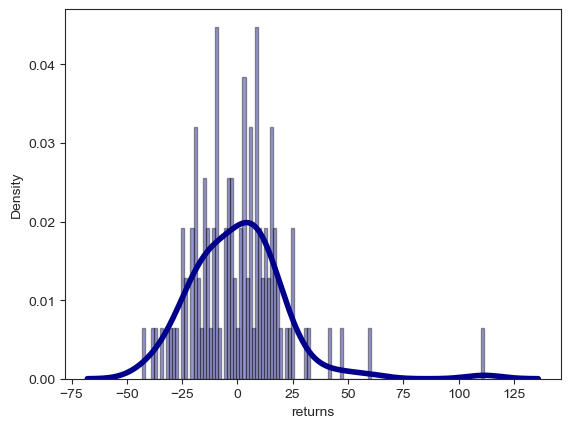

In [19]:
seaborn.distplot(moments['returns'], hist=True, kde=True, 
             bins=int(112), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

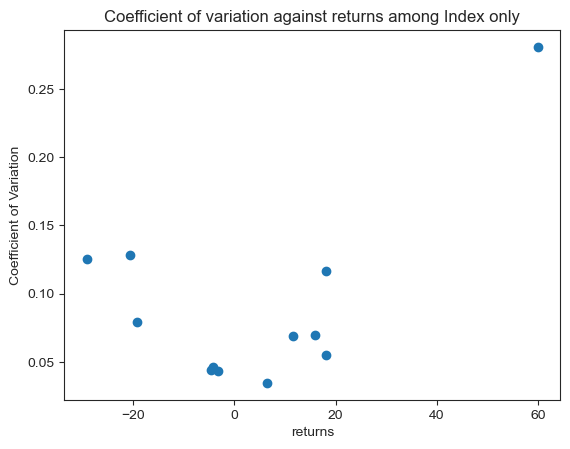

In [20]:
plt.scatter(moments_macro['returns'], moments_macro['coef var'],)

# Set the x-axis label
plt.xlabel('returns')

# Set the y-axis label
plt.ylabel('Coefficient of Variation')

plt.title('Coefficient of variation against returns among Index only')

# Show the plot
plt.show()

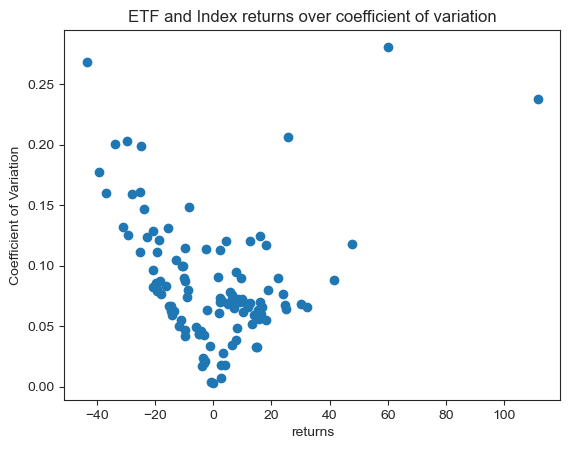

In [21]:
plt.scatter(moments['returns'], moments['coef var'],)

# Set the x-axis label
plt.xlabel('returns')

# Set the y-axis label
plt.ylabel('Coefficient of Variation')

plt.title('ETF and Index returns over coefficient of variation')

# Show the plot
plt.show()

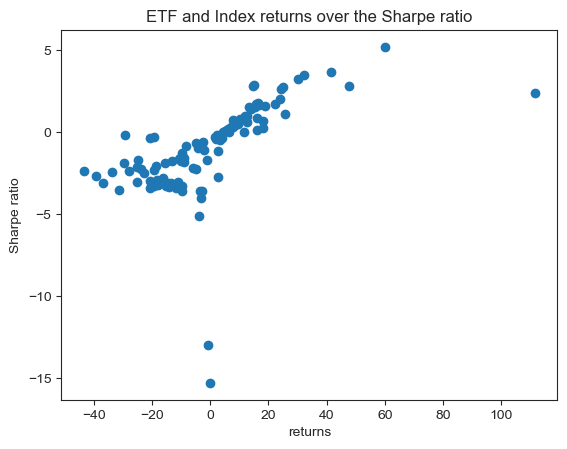

In [22]:
plt.scatter(moments['returns'], moments['Sharpe ratio'],)

# Set the x-axis label
plt.xlabel('returns')

# Set the y-axis label
plt.ylabel('Sharpe ratio')

plt.title('ETF and Index returns over the Sharpe ratio')

# Show the plot
plt.show()

# Clustering on the coefficient of variation

# K-means clustering

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


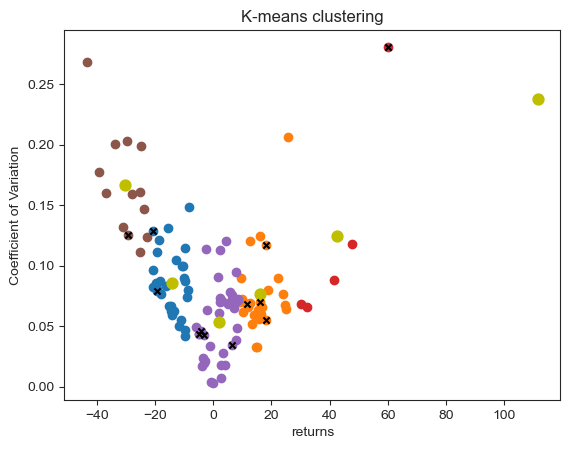

In [23]:
# define the model
model = KMeans(n_clusters=6)

# dataset
X = moments[['returns', 'coef var']].values

# fit the model
model.fit(X)

# assign a cluster to each example
yhat = model.predict(X)

# retrieve unique clusters and centroids
clusters = np.unique(yhat)
centroids = model.cluster_centers_

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
    
# add centroids to the plot
plt.scatter(centroids[:, 0], centroids[:, 1], s=34, linewidths=3, color='y')
plt.scatter(moments_macro['returns'], moments_macro['coef var'], s= 20, marker='x', color = 'k')

# Set the x-axis label
plt.xlabel('returns')

# Set the y-axis label
plt.ylabel('Coefficient of Variation')
plt.title('K-means clustering')

# show the plot
plt.show()


Yellow dots are the clusters centroids.
Black cross are the Index points (macro factors)
All the others dots are our ETF

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting t

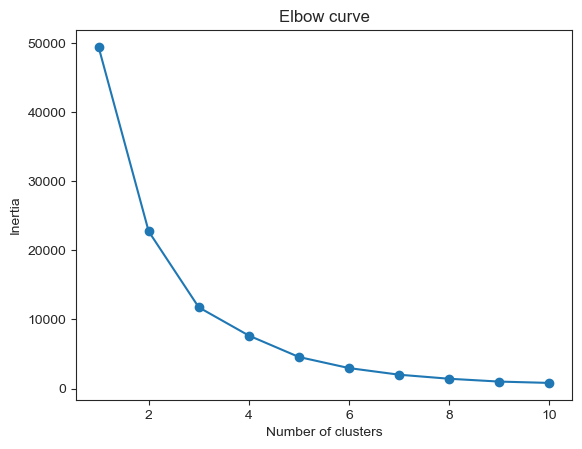

In [24]:
# Create an empty list to store the inertia values
inertia = []

# Define the range of cluster numbers to try
clusters_range = range(1, 11)

# Loop through different numbers of clusters
for k in clusters_range:
    # Create a KMeans model with k clusters
    model = KMeans(n_clusters=k, random_state=42)
    # Fit the model to the data
    model.fit(X)
    # Append the inertia to the list
    inertia.append(model.inertia_)

# Plot the elbow curve
plt.plot(clusters_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve')
plt.show()

# Adding the clusters identification to the data

In [25]:
# fit the model and get the cluster labels
cluster_labels = model.fit_predict(X)
classification = moments.assign(cluster=cluster_labels)
classification

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


mean       stdev    returns  coef var  \
ETF_1                     86.163318   17.161389 -24.779120  0.199173   
ETF_2                    110.611161   13.287454  12.782966  0.120128   
ETF_3                    116.400217   10.478816  22.357992  0.090024   
ETF_4                     77.546017   10.211074 -31.149997  0.131678   
ETF_5                    106.507268    4.129238   7.810212  0.038770   
...                             ...         ...        ...       ...   
BCOM Industrial Metals   164.315915   19.197382  18.025767  0.116832   
BCOM Gold                198.213625    8.542641  -3.285611  0.043098   
Dollar Index            1152.923664   80.455146  15.940474  0.069784   
US 10Y Bond             1059.905413   83.796698 -19.308782  0.079061   
Germany Bund 10Y        1555.875280  194.707928 -29.150169  0.125144   

                        risk reward  Sharpe ratio  cluster  
ETF_1                   -124.410163     -1.718924        6  
ETF_2                    106.411561      0.606810        0  
ETF_3                    248.355841      1.683205        7  
ETF_4                   -236.562594     -3.512852        6  
ETF_5                    201.452285      0.748374        8  
...                             ...           ...      ...  
BCOM Industrial Metals   154.287725      0.693103        0  
BCOM Gold                -76.235532     -0.937135        4  
Dollar Index             228.427277      0.139462        0  
US 10Y Bond             -244.227791     -0.286751        9  
Germany Bund 10Y        -232.933645     -0.173954        6  

[113 rows x 7 columns]

In [26]:
classification.iloc[40]

mean            187.557699
stdev            44.570138
returns         111.513207
coef var          0.237634
risk reward     469.263986
Sharpe ratio      2.396071
cluster           5.000000
Name: ETF_41, dtype: float64

# Index clusters

In [27]:
classification.iloc[-12:]

mean        stdev    returns  coef var  \
US S&P 500               7668.516003   527.006350  11.519765  0.068723   
EU Stoxx 600             1004.096690    55.506069  18.098873  0.055280   
Japan Nikkei 225        47122.240755  1624.776070   6.403639  0.034480   
MSCI EM USD               571.416528    73.426632 -20.709513  0.128499   
US HY                     313.719423    13.770712  -4.727549  0.043895   
EU HY                     203.568884     9.422265  -4.332767  0.046285   
BCOM Energy                37.925627    10.645386  59.945693  0.280691   
BCOM Industrial Metals    164.315915    19.197382  18.025767  0.116832   
BCOM Gold                 198.213625     8.542641  -3.285611  0.043098   
Dollar Index             1152.923664    80.455146  15.940474  0.069784   
US 10Y Bond              1059.905413    83.796698 -19.308782  0.079061   
Germany Bund 10Y         1555.875280   194.707928 -29.150169  0.125144   

                        risk reward  Sharpe ratio  cluster  
US S&P 500               167.625120      0.012903        0  
EU Stoxx 600             327.405970      0.241034        0  
Japan Nikkei 225         185.720262      0.001036        8  
MSCI EM USD             -161.164386     -0.346325        9  
US HY                   -107.701332     -0.686061        4  
EU HY                    -93.609830     -0.960785        4  
BCOM Energy              213.564643      5.187759        2  
BCOM Industrial Metals   154.287725      0.693103        0  
BCOM Gold                -76.235532     -0.937135        4  
Dollar Index             228.427277      0.139462        0  
US 10Y Bond             -244.227791     -0.286751        9  
Germany Bund 10Y        -232.933645     -0.173954        6

From above we can see that among our index we have a poor classification, for instance equity indexes like EURStoxx and S&P are put with BCOM industrial metals. Samely, US 10Y bond is not put alltogether with Germany bund 10Y.

# gaussian mixture clustering

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


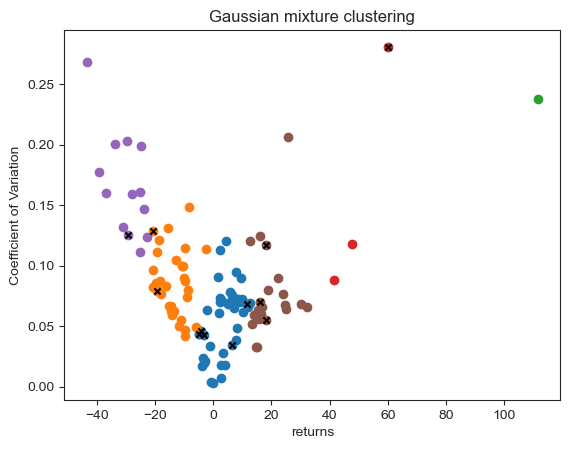

In [28]:
# define the model
model = GaussianMixture(n_components=6)

# dataset
X = moments[['returns', 'coef var']].values

# fit the model
model.fit(X)

# assign a cluster to each example
yhat = model.predict(X)

# retrieve unique clusters and centroids
clusters = np.unique(yhat)
#centroids = model.cluster_centers_

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
    
# add centroids to the plot
#plt.scatter(centroids[:, 0], centroids[:, 1], s=34, linewidths=3, color='y')
plt.scatter(moments_macro['returns'], moments_macro['coef var'], s= 20, marker='x', color = 'k')

# Set the x-axis label
plt.xlabel('returns')

# Set the y-axis label
plt.ylabel('Coefficient of Variation')
plt.title('Gaussian mixture clustering')
# show the plot
plt.show()


There is not much difference in the fineness of the clustering between the K-means and Gaussian mixture.

# Clustering over the Sharpe ratio

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


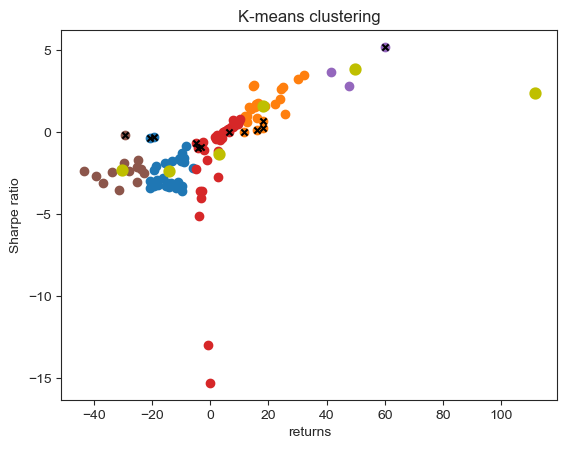

In [29]:
# define the model
model = KMeans(n_clusters=6)

# dataset
X = moments[['returns', 'Sharpe ratio']].values

# fit the model
model.fit(X)

# assign a cluster to each example
yhat = model.predict(X)

# retrieve unique clusters and centroids
clusters = np.unique(yhat)
centroids = model.cluster_centers_

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
    
# add centroids to the plot
plt.scatter(centroids[:, 0], centroids[:, 1], s=34, linewidths=3, color='y')
plt.scatter(moments_macro['returns'], moments_macro['Sharpe ratio'], s= 20, marker='x', color = 'k')

# Set the x-axis label
plt.xlabel('returns')

# Set the y-axis label
plt.ylabel('Sharpe ratio')
plt.title('K-means clustering')

# show the plot
plt.show()


Yellow dots are the clusters centroids. Black cross are the Index points (macro factors) All the others dots are our ETF

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting t

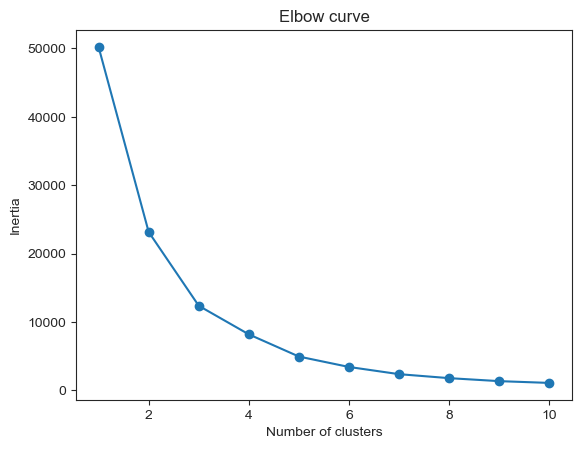

In [30]:
# Create an empty list to store the inertia values
inertia = []

# Define the range of cluster numbers to try
clusters_range = range(1, 11)

# Loop through different numbers of clusters
for k in clusters_range:
    # Create a KMeans model with k clusters
    model = KMeans(n_clusters=k, random_state=42)
    # Fit the model to the data
    model.fit(X)
    # Append the inertia to the list
    inertia.append(model.inertia_)

# Plot the elbow curve
plt.plot(clusters_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve')
plt.show()

# Gaussian mixture

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


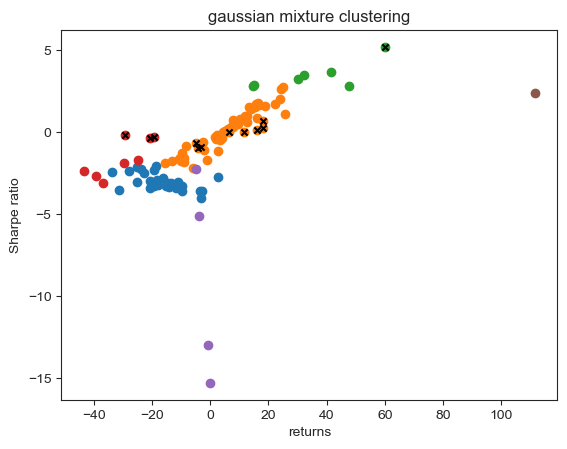

In [31]:
# define the model
model = GaussianMixture(n_components=6)

# dataset
X = moments[['returns', 'Sharpe ratio']].values

# fit the model
model.fit(X)

# assign a cluster to each example
yhat = model.predict(X)

# retrieve unique clusters and centroids
clusters = np.unique(yhat)
#centroids = model.cluster_centers_

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
    
# add centroids to the plot
#plt.scatter(centroids[:, 0], centroids[:, 1], s=34, linewidths=3, color='y')
plt.scatter(moments_macro['returns'], moments_macro['Sharpe ratio'], s= 20, marker='x', color = 'k')

# Set the x-axis label
plt.xlabel('returns')

# Set the y-axis label
plt.ylabel('Sharpe ratio')
plt.title('gaussian mixture clustering')
# show the plot
plt.show()


The gaussian seems better.

# Adding those cluster to the dataframe

In [32]:
# fit the model and get the cluster labels
cluster_labels = model.fit_predict(X)
classification = moments.assign(cluster_2=cluster_labels)
classification

C:\Users\Baptiste\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


mean       stdev    returns  coef var  \
ETF_1                     86.163318   17.161389 -24.779120  0.199173   
ETF_2                    110.611161   13.287454  12.782966  0.120128   
ETF_3                    116.400217   10.478816  22.357992  0.090024   
ETF_4                     77.546017   10.211074 -31.149997  0.131678   
ETF_5                    106.507268    4.129238   7.810212  0.038770   
...                             ...         ...        ...       ...   
BCOM Industrial Metals   164.315915   19.197382  18.025767  0.116832   
BCOM Gold                198.213625    8.542641  -3.285611  0.043098   
Dollar Index            1152.923664   80.455146  15.940474  0.069784   
US 10Y Bond             1059.905413   83.796698 -19.308782  0.079061   
Germany Bund 10Y        1555.875280  194.707928 -29.150169  0.125144   

                        risk reward  Sharpe ratio  cluster_2  
ETF_1                   -124.410163     -1.718924          3  
ETF_2                    106.411561      0.606810          2  
ETF_3                    248.355841      1.683205          2  
ETF_4                   -236.562594     -3.512852          3  
ETF_5                    201.452285      0.748374          4  
...                             ...           ...        ...  
BCOM Industrial Metals   154.287725      0.693103          2  
BCOM Gold                -76.235532     -0.937135          4  
Dollar Index             228.427277      0.139462          2  
US 10Y Bond             -244.227791     -0.286751          3  
Germany Bund 10Y        -232.933645     -0.173954          3  

[113 rows x 7 columns]

In [33]:
classification.iloc[40]

mean            187.557699
stdev            44.570138
returns         111.513207
coef var          0.237634
risk reward     469.263986
Sharpe ratio      2.396071
cluster_2         5.000000
Name: ETF_41, dtype: float64

# Index clusters 2

In [34]:
classification.iloc[-12:]

mean        stdev    returns  coef var  \
US S&P 500               7668.516003   527.006350  11.519765  0.068723   
EU Stoxx 600             1004.096690    55.506069  18.098873  0.055280   
Japan Nikkei 225        47122.240755  1624.776070   6.403639  0.034480   
MSCI EM USD               571.416528    73.426632 -20.709513  0.128499   
US HY                     313.719423    13.770712  -4.727549  0.043895   
EU HY                     203.568884     9.422265  -4.332767  0.046285   
BCOM Energy                37.925627    10.645386  59.945693  0.280691   
BCOM Industrial Metals    164.315915    19.197382  18.025767  0.116832   
BCOM Gold                 198.213625     8.542641  -3.285611  0.043098   
Dollar Index             1152.923664    80.455146  15.940474  0.069784   
US 10Y Bond              1059.905413    83.796698 -19.308782  0.079061   
Germany Bund 10Y         1555.875280   194.707928 -29.150169  0.125144   

                        risk reward  Sharpe ratio  cluster_2  
US S&P 500               167.625120      0.012903          2  
EU Stoxx 600             327.405970      0.241034          2  
Japan Nikkei 225         185.720262      0.001036          4  
MSCI EM USD             -161.164386     -0.346325          3  
US HY                   -107.701332     -0.686061          0  
EU HY                    -93.609830     -0.960785          0  
BCOM Energy              213.564643      5.187759          1  
BCOM Industrial Metals   154.287725      0.693103          2  
BCOM Gold                -76.235532     -0.937135          4  
Dollar Index             228.427277      0.139462          2  
US 10Y Bond             -244.227791     -0.286751          3  
Germany Bund 10Y        -232.933645     -0.173954          3

# Correlation coefficients

In [35]:
corr_df = merged_df2.corr(method='pearson')
#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
#del corr_df.index.name
corr_df.head(10)

ETF_1     ETF_2     ETF_3     ETF_4     ETF_5     ETF_6     ETF_7  \
ETF_1   1.000000  0.754509  0.548259  0.599096  0.398017  0.954580  0.690995   
ETF_2   0.754509  1.000000  0.812415  0.239324  0.757827  0.815250  0.610818   
ETF_3   0.548259  0.812415  1.000000 -0.087083  0.613366  0.596705  0.546930   
ETF_4   0.599096  0.239324 -0.087083  1.000000  0.118539  0.551704  0.152952   
ETF_5   0.398017  0.757827  0.613366  0.118539  1.000000  0.525246  0.357699   
ETF_6   0.954580  0.815250  0.596705  0.551704  0.525246  1.000000  0.726809   
ETF_7   0.690995  0.610818  0.546930  0.152952  0.357699  0.726809  1.000000   
ETF_8   0.680781  0.877924  0.757503  0.173537  0.707208  0.773228  0.743023   
ETF_9   0.678581  0.464589  0.374846  0.354755  0.053985  0.677805  0.747108   
ETF_10  0.385901  0.542437  0.337676  0.045757  0.486374  0.476334  0.702210   

           ETF_8     ETF_9    ETF_10  ...  Japan Nikkei 225  MSCI EM USD  \
ETF_1   0.680781  0.678581  0.385901  ...          0.480949     0.966773   
ETF_2   0.877924  0.464589  0.542437  ...          0.491549     0.657200   
ETF_3   0.757503  0.374846  0.337676  ...          0.404694     0.497684   
ETF_4   0.173537  0.354755  0.045757  ...          0.417037     0.621336   
ETF_5   0.707208  0.053985  0.486374  ...          0.725301     0.296088   
ETF_6   0.773228  0.677805  0.476334  ...          0.501225     0.941816   
ETF_7   0.743023  0.747108  0.702210  ...          0.197638     0.722728   
ETF_8   1.000000  0.554407  0.720331  ...          0.340840     0.631058   
ETF_9   0.554407  1.000000  0.425355  ...          0.046272     0.738919   
ETF_10  0.720331  0.425355  1.000000  ...          0.040979     0.352649   

           US HY     EU HY  BCOM Energy  BCOM Industrial Metals  BCOM Gold  \
ETF_1   0.925044  0.939442    -0.811229               -0.167812   0.273745   
ETF_2   0.874607  0.856737    -0.566959                0.103181   0.261683   
ETF_3   0.681583  0.699537    -0.459890                0.120032   0.201162   
ETF_4   0.441609  0.441631    -0.555427               -0.435700   0.124094   
ETF_5   0.537381  0.497601    -0.159642                0.090381  -0.024820   
ETF_6   0.956393  0.964953    -0.772186               -0.049308   0.350075   
ETF_7   0.785858  0.777235    -0.335175                0.420326   0.525313   
ETF_8   0.837991  0.817168    -0.429341                0.346247   0.467389   
ETF_9   0.683122  0.717513    -0.544285                0.354239   0.812223   
ETF_10  0.578925  0.519887     0.044861                0.591545   0.453783   

        Dollar Index  US 10Y Bond  Germany Bund 10Y  
ETF_1      -0.947424     0.945479          0.925182  
ETF_2      -0.656509     0.656224          0.652864  
ETF_3      -0.493947     0.407194          0.408924  
ETF_4      -0.571521     0.594075          0.555615  
ETF_5      -0.242232     0.306489          0.337637  
ETF_6      -0.939291     0.925261          0.906089  
ETF_7      -0.742728     0.719325          0.749379  
ETF_8      -0.635390     0.647509          0.671041  
ETF_9      -0.806135     0.649110          0.626318  
ETF_10     -0.369438     0.499580          0.575980  

[10 rows x 113 columns]

In [36]:
plt.figure(figsize=(130, 80))
seaborn.heatmap(corr_df, annot=True, cmap='Blues')
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [37]:
corr_df_macro = corr_df.T.iloc[:-12,101:]

<Figure size 640x480 with 0 Axes>

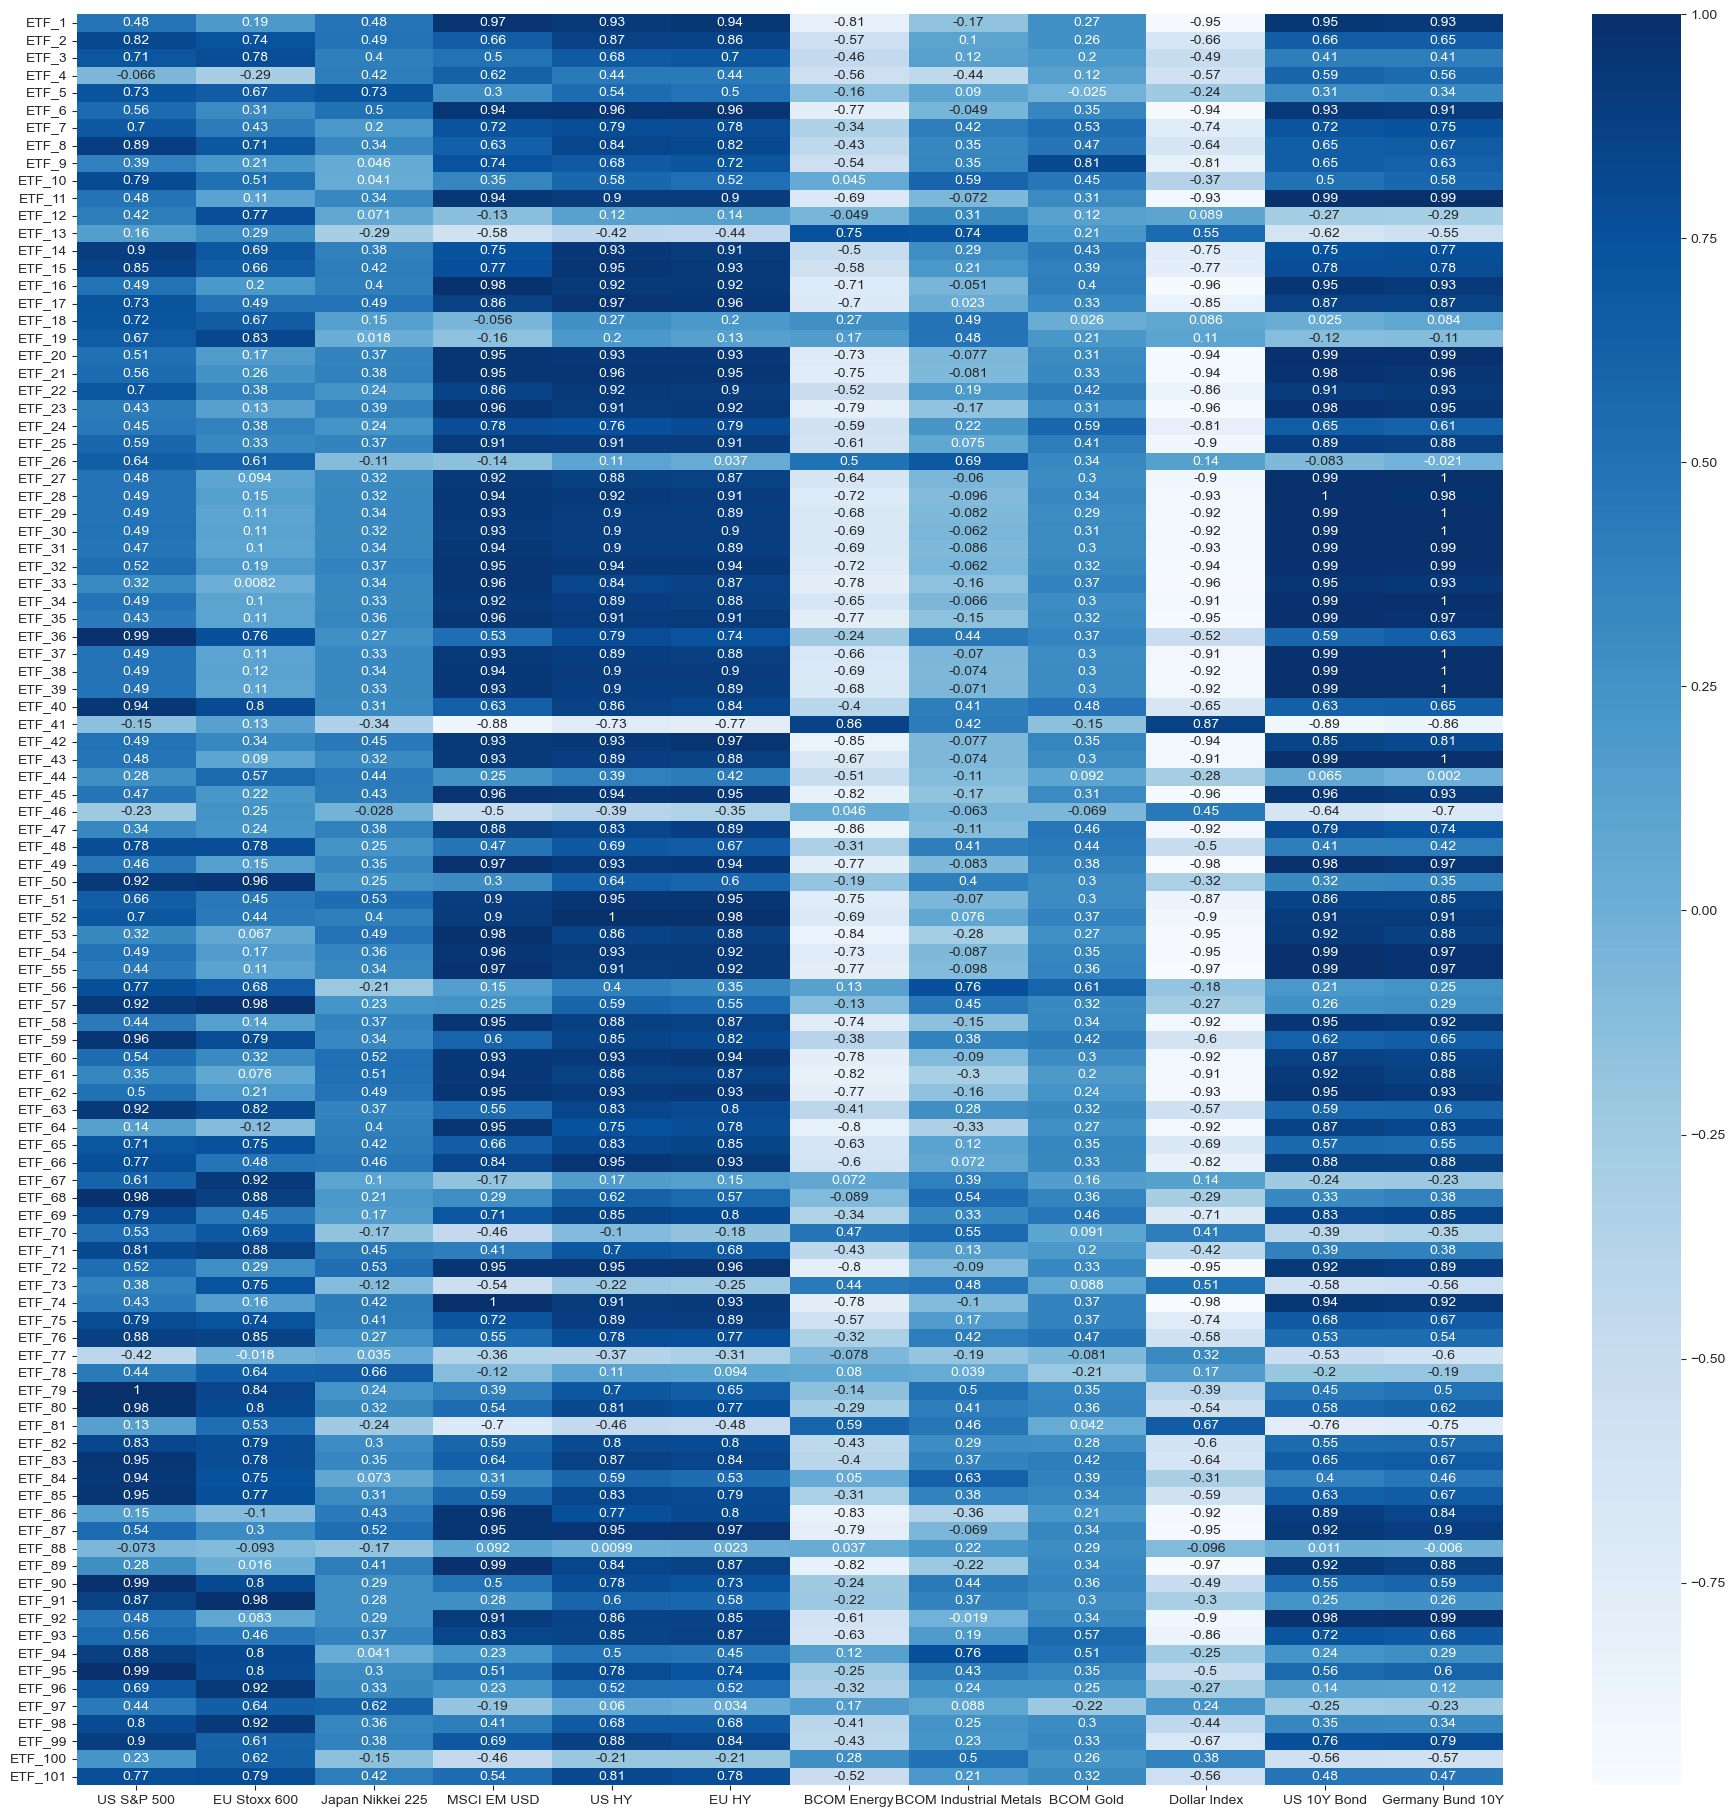

<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure(figsize=(23, 23))
seaborn.heatmap(corr_df_macro, annot=True, cmap='Blues')
plt.figure()

# Mystery allocation

# Lasso regression

In [39]:
#moments
from sklearn import linear_model
# define model
model = linear_model.Lasso(alpha=1.0)

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# load the dataset
data = moments.values
X, y = data[:, :-1], data[:, -1]
# define model
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 1.779 (2.724)


In [40]:
ETF_universe["Unnamed: 0"] = pd.to_datetime(ETF_universe["Unnamed: 0"])
Mystery_allocation["Unnamed: 0"] = pd.to_datetime(Mystery_allocation["Unnamed: 0"])

combined_data = pd.merge(ETF_universe, Mystery_allocation, on='Unnamed: 0')
combined_data

Unnamed: 0       ETF_1       ETF_2       ETF_3       ETF_4       ETF_5  \
0   2021-01-04  100.000000  100.000000  100.000000  100.000000  100.000000   
1   2021-01-05  100.664447  100.083922   99.252395  102.032069  100.041029   
2   2021-01-06   98.549788   99.519065   98.364484  107.519936   99.698544   
3   2021-01-07   99.735901   98.684154   99.717292  114.954919  101.233032   
4   2021-01-08  101.813931  101.323378   99.264960  116.151961  103.332426   
..         ...         ...         ...         ...         ...         ...   
578 2023-03-23   74.868592  113.657686  121.902518   68.095661  106.478710   
579 2023-03-24   75.202682  111.067955  119.537197   67.401513  106.473096   
580 2023-03-27   74.952348  111.341238  121.790482   67.562456  106.564655   
581 2023-03-28   74.244973  109.850017  122.177896   67.566298  106.665717   
582 2023-03-29   75.220880  112.782966  122.357992   68.850003  107.810212   

          ETF_6       ETF_7       ETF_8       ETF_9  ...      ETF_93  \
0    100.000000  100.000000  100.000000  100.000000  ...  100.000000   
1    100.269482   99.779466  101.721018   99.633393  ...  100.840152   
2     99.834420  101.532557  101.561550   99.624949  ...  100.057308   
3    101.019559  103.712486  104.576537   99.222455  ...  101.206768   
4    103.120770  104.025163  105.525583   95.806184  ...  102.608099   
..          ...         ...         ...         ...  ...         ...   
578   86.832247   90.525182  117.126901   82.487299  ...   97.192487   
579   86.952706   90.170160  115.425105   83.089632  ...   96.230280   
580   86.510194   90.180661  114.424591   83.051635  ...   96.112236   
581   87.146849   90.373417  113.297791   84.563097  ...   97.452443   
582   87.045017   91.166796  116.201824   84.356221  ...   97.798749   

         ETF_94      ETF_95      ETF_96      ETF_97      ETF_98      ETF_99  \
0    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1    101.002981  100.739760   99.536130   99.813980   99.603933  100.854623   
2    102.128050  101.231133  101.309788   99.944805  100.964540   99.444345   
3    103.191639  102.864413  101.628140  101.677728  101.444481  101.936676   
4    103.597696  103.454080  102.263032  103.375352  102.152742  103.242398   
..          ...         ...         ...         ...         ...         ...   
578  109.206061  106.271420  123.709405  112.732806  116.224780  101.517271   
579  108.603153  106.829062  121.535832  112.591472  114.137272  101.818816   
580  109.833182  107.029701  122.535942  112.921116  115.208984  101.069376   
581  110.583040  106.854142  122.641585  113.302632  115.264899  100.570910   
582  112.021290  108.403404  124.497194  114.839521  116.923722  102.448725   

        ETF_100     ETF_101  Mystery_Allocation  
0    100.000000  100.000000          100.000000  
1    100.202380  100.031821          100.411114  
2    102.497743  100.158991          100.928422  
3    102.922817  100.254745          101.507654  
4    103.967763  100.326256          101.965763  
..          ...         ...                 ...  
578  136.156331  102.581525           96.635446  
579  135.991859  102.208289           96.623805  
580  136.940118  102.276907           96.258588  
581  138.793038  102.132843           96.276506  
582  141.634001  102.671261           97.297423  

[583 rows x 103 columns]

In [41]:
# Step 1: Load the necessary libraries and import the data
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

combined_data2 = combined_data.drop('Unnamed: 0', axis = 1)

# Step 2: Prepare the data
X = combined_data2.iloc[:, :-1]
y = combined_data2.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Step 3: Train the LASSO regression model
lasso = Lasso(alpha=0.1, positive=True)
lasso.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = lasso.predict(X_test)
mse = np.mean((y_pred - y_test) ** 2)
r_squared = lasso.score(X_test, y_test)

# Step 5: Interpret the results
coefficients = pd.DataFrame(lasso.coef_, index=X.columns, columns=['Coefficient'])
allocation = coefficients / coefficients.sum()
allocation

Coefficient
ETF_1       0.000000
ETF_2       0.010180
ETF_3       0.001536
ETF_4       0.000000
ETF_5       0.000000
...              ...
ETF_97      0.000000
ETF_98      0.000000
ETF_99      0.022695
ETF_100     0.031266
ETF_101     0.000000

[101 rows x 1 columns]

In [42]:
allocation.sum()

Coefficient    1.0
dtype: float64

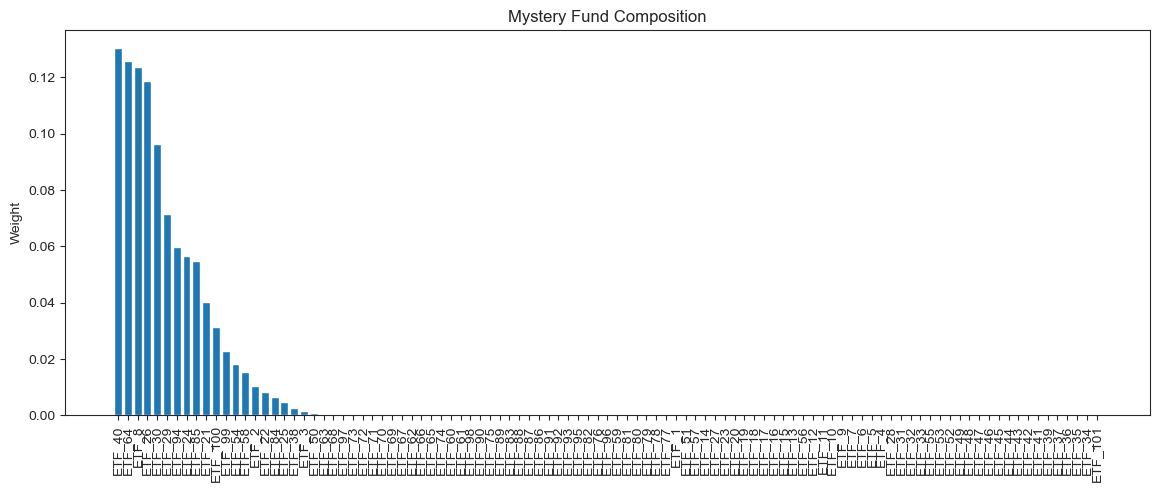

In [43]:
# Sort the allocation by weight in descending order
allocation = allocation.sort_values('Coefficient', ascending=False)

# Create a bar plot of the mystery fund's composition
plt.figure(figsize=(14,5))
plt.bar(allocation.index, allocation['Coefficient'])
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.title('Mystery Fund Composition')
plt.show()

In [44]:
allocation = allocation.sort_values('Coefficient', ascending=True)
allocation.iloc[101-19:]

Coefficient
ETF_38      0.002717
ETF_25      0.004510
ETF_84      0.006557
ETF_22      0.008337
ETF_2       0.010180
ETF_58      0.015410
ETF_54      0.018261
ETF_99      0.022695
ETF_100     0.031266
ETF_21      0.040272
ETF_85      0.054653
ETF_24      0.056615
ETF_94      0.059818
ETF_29      0.071535
ETF_30      0.096423
ETF_26      0.118569
ETF_8       0.123662
ETF_64      0.125976
ETF_40      0.130250

# Mystery allocation v2

# Kalman filter

In [45]:
ETF_universe["Unnamed: 0"] = pd.to_datetime(ETF_universe["Unnamed: 0"])
Mystery_allocation_v2["Unnamed: 0"] = pd.to_datetime(Mystery_allocation["Unnamed: 0"])

combined_data_v2 = pd.merge(ETF_universe, Mystery_allocation_v2, on='Unnamed: 0')
combined_data2_v2 = combined_data_v2.drop('Unnamed: 0', axis = 1)
combined_data2_v2

ETF_1       ETF_2       ETF_3       ETF_4       ETF_5       ETF_6  \
0    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1    100.664447  100.083922   99.252395  102.032069  100.041029  100.269482   
2     98.549788   99.519065   98.364484  107.519936   99.698544   99.834420   
3     99.735901   98.684154   99.717292  114.954919  101.233032  101.019559   
4    101.813931  101.323378   99.264960  116.151961  103.332426  103.120770   
..          ...         ...         ...         ...         ...         ...   
578   74.868592  113.657686  121.902518   68.095661  106.478710   86.832247   
579   75.202682  111.067955  119.537197   67.401513  106.473096   86.952706   
580   74.952348  111.341238  121.790482   67.562456  106.564655   86.510194   
581   74.244973  109.850017  122.177896   67.566298  106.665717   87.146849   
582   75.220880  112.782966  122.357992   68.850003  107.810212   87.045017   

          ETF_7       ETF_8       ETF_9      ETF_10  ...      ETF_93  \
0    100.000000  100.000000  100.000000  100.000000  ...  100.000000   
1     99.779466  101.721018   99.633393  100.025174  ...  100.840152   
2    101.532557  101.561550   99.624949  100.121489  ...  100.057308   
3    103.712486  104.576537   99.222455  100.238511  ...  101.206768   
4    104.025163  105.525583   95.806184  100.473455  ...  102.608099   
..          ...         ...         ...         ...  ...         ...   
578   90.525182  117.126901   82.487299   99.325409  ...   97.192487   
579   90.170160  115.425105   83.089632   99.410211  ...   96.230280   
580   90.180661  114.424591   83.051635   98.971767  ...   96.112236   
581   90.373417  113.297791   84.563097   98.612283  ...   97.452443   
582   91.166796  116.201824   84.356221   98.769557  ...   97.798749   

         ETF_94      ETF_95      ETF_96      ETF_97      ETF_98      ETF_99  \
0    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1    101.002981  100.739760   99.536130   99.813980   99.603933  100.854623   
2    102.128050  101.231133  101.309788   99.944805  100.964540   99.444345   
3    103.191639  102.864413  101.628140  101.677728  101.444481  101.936676   
4    103.597696  103.454080  102.263032  103.375352  102.152742  103.242398   
..          ...         ...         ...         ...         ...         ...   
578  109.206061  106.271420  123.709405  112.732806  116.224780  101.517271   
579  108.603153  106.829062  121.535832  112.591472  114.137272  101.818816   
580  109.833182  107.029701  122.535942  112.921116  115.208984  101.069376   
581  110.583040  106.854142  122.641585  113.302632  115.264899  100.570910   
582  112.021290  108.403404  124.497194  114.839521  116.923722  102.448725   

        ETF_100     ETF_101  Mystery_Allocation  
0    100.000000  100.000000          100.000000  
1    100.202380  100.031821          100.448236  
2    102.497743  100.158991          100.450441  
3    102.922817  100.254745          101.512831  
4    103.967763  100.326256          102.788447  
..          ...         ...                 ...  
578  136.156331  102.581525          105.435290  
579  135.991859  102.208289          104.890943  
580  136.940118  102.276907          105.441925  
581  138.793038  102.132843          105.902129  
582  141.634001  102.671261          106.019394  

[583 rows x 102 columns]

In [46]:
from pykalman import KalmanFilter

In [47]:
X = combined_data2_v2.iloc[:, :-1]
y = combined_data2_v2.iloc[:, -1]

In [48]:
kf = KalmanFilter(n_dim_obs=100, n_dim_state=100)

In [49]:
initial_state_mean = allocation['Coefficient'].values
initial_state_covariance = np.diag(np.ones(100) * 0.01)

In [50]:
transition_matrix = np.eye(100)

In [51]:
observation_matrix = np.eye(100)

In [52]:
estimated_weights = []
state_mean = initial_state_mean
state_covariance = initial_state_covariance

for i in range(len(combined_data2_v2)):
    # Get the observed prices of the ETFs for this day
    observation = combined_data2_v2.iloc[i, :-1].values
    
    # Use the Kalman filter to estimate the weights of the mystery fund for this day
    state_mean, state_covariance = kf.filter_update(state_mean, state_covariance, observation, transition_matrix, observation_matrix)
    
    # Store the estimated weights for this day in a DataFrame
    estimated_weights.append(state_mean)
    
estimated_weights = pd.DataFrame(estimated_weights, columns=allocation.index)

ValueError: transition_offset is not constant for all time.  You must specify it manually.

In [55]:
# Sélectionner les colonnes des ETFs seulement (sans la colonne Mystery_allocation_v2)
etf_columns = [col for col in combined_data2_v2.columns if col.startswith('ETF')]
df_etfs = combined_data2_v2[etf_columns]

# Créer un modèle de filtre de Kalman
kf = KalmanFilter(
    n_dim_obs=df_etfs.shape[1],  # Nombre d'ETFs dans l'allocation mystère
    n_dim_state=df_etfs.shape[1],          # Dimension de l'état caché (les poids des ETFs)
    observation_matrices=np.ones((df_etfs.shape[1], df_etfs.shape[1])),  # Matrice d'observation
    transition_matrices=np.eye(df_etfs.shape[1]),                  # Matrice de transition
    observation_covariance=np.eye(df_etfs.shape[1]),     # Covariance de bruit de mesure
    transition_covariance=np.eye(df_etfs.shape[1]),                # Covariance de bruit de processus
    initial_state_mean=df_etfs.iloc[0].values,           # Valeur initiale de l'état caché
    initial_state_covariance=np.eye(df_etfs.shape[1])              # Covariance initiale de l'état caché
)

# Appliquer le filtre de Kalman aux données d'allocation mystère
filtered_state_means, filtered_state_covariances = kf.filter(Mystery_allocation_v2.drop('Unnamed: 0', axis=1).values)

# Récupérer les prévisions pour les valeurs de l'allocation mystère
allocation_mystere_weights = pd.DataFrame(filtered_state_means, columns=df_etfs.columns, index=combined_data2_v2.index)
allocation_mystere_weights = allocation_mystere_weights.div(len(etf_columns))
allocation_mystere_weights



ValueError: could not broadcast input array from shape (101,101) into shape (101,1)